In [12]:
import os
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.pyplot import imshow
import cv2
from PIL import Image
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/characters/')

In [15]:
classesDF=pd.read_csv("classlabels.csv")
trnDF=pd.read_csv("TRN.csv").merge(classesDF, on="label").drop("label", axis=1)
valDF=pd.read_csv("VAL.csv").merge(classesDF, on="label").drop("label", axis=1)
tstDF=pd.read_csv("TST.csv").merge(classesDF, on="label").drop("label", axis=1)
txnDF=pd.read_csv("TXN.csv").merge(classesDF, on="label").drop("label", axis=1)

In [16]:
X_train_files = trnDF['name'].values
X_validate_files = valDF['name'].values
X_test_files = tstDF['name'].values

In [17]:
# find average size of images
all_files = np.hstack((X_train_files, X_validate_files, X_test_files)).ravel()
#widths = []
#heighths = []
#for image_filename in all_files:
#    image = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
#    h,w = image.shape # rows, columns
#    widths.append(w)
#    heighths.append(h)

In [18]:
#g = sns.jointplot(x=widths, y=heighths);
#g.fig.set_figwidth(10)
#g.fig.set_figheight(10)

In [19]:
#pd.DataFrame({'heighths': heighths, 'widths': widths}).describe().transpose()

In [20]:
image_w = 128
image_h = 128
#image_shape = (image_h, image_w, 3)
#color_mode = "rgb"
image_shape = (image_h, image_w, 1)
color_mode = "grayscale"

batch_size = 128

In [21]:
index = [i for i,f in enumerate(all_files) if f.endswith('img014-00069.png')][0]

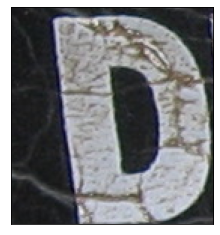

In [22]:
cimg = imread(all_files[index], cv2.IMREAD_COLOR)
fig = imshow(cimg);
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

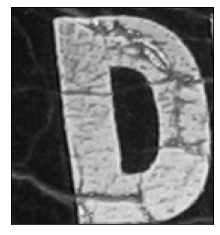

In [23]:
img = cv2.cvtColor(cimg, cv2.COLOR_BGR2GRAY)
fig = imshow(img, cmap="gray");
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

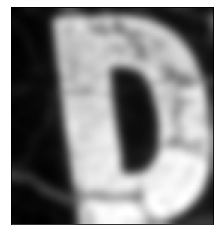

In [24]:
gimg = cv2.GaussianBlur(img, ksize=(0,0), sigmaX=3, sigmaY=3)
fig = imshow(gimg, cmap="gray");
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

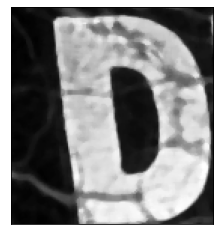

In [25]:
mimg = cv2.medianBlur(img, ksize=5)
fig = imshow(mimg, cmap="gray");
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

100.0


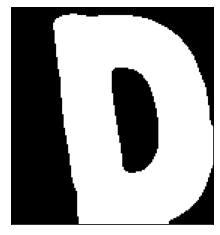

In [26]:
th, oimg = cv2.threshold(gimg, 128, 255, cv2.THRESH_OTSU)
print(th)
fig = imshow(oimg, cmap="gray");
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

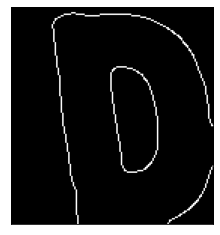

In [27]:
eimg = cv2.Canny(oimg, 100, 200)
fig = imshow(eimg, cmap="gray");
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [28]:
def preprocessing_function(img):
  """Input and output same shape of image"""
  depth = np.ndim(img)
  is_grayscale = depth == 2
  if depth == 3:
    if img.shape[-1] == 1:
      img = np.squeeze(img, axis=-1) # remove singleton dimensions
      is_grayscale = True
    else:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
  img = cv2.GaussianBlur(img, ksize=(0,0), sigmaX=3, sigmaY=3).astype('uint8') # Gaussian smoothing
  #img = cv2.medianBlur(img, ksize=5).astype('uint8') # median smoothing
  _, img = cv2.threshold(img, 128, 255, cv2.THRESH_OTSU) # Otsu's thresholding
  img = cv2.Canny(img, 100, 200) # edge detector
  if depth == 3:
    img = np.expand_dims(img, axis=2) # 2D -> 3D
    if not is_grayscale:
      img = np.repeat(img, 3, axis=2) # treat grayscale as color
  return img.astype('float64')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


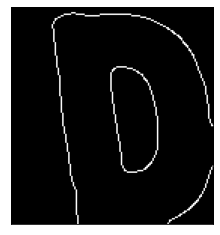

In [29]:
pimg = preprocessing_function(cimg)
fig = imshow(pimg, cmap="gray");
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [109]:
pimg.shape

(145, 135, 3)

In [110]:
# randomize training image generator to reduce overfitting
training_image_generator = ImageDataGenerator(
    rotation_range=30, # rotate the image up to 30 degrees
    width_shift_range=0.20, # Shift the pic width by a max of 20%
    height_shift_range=0.20, # Shift the pic height by a max of 20%
    rescale=1/255, # Rescale the image by normalizing it.
    shear_range=0.20, # Shear means cutting away part of the image (max 20%)
    zoom_range=0.20, # Zoom in by 20% max
    preprocessing_function=preprocessing_function
)

In [111]:
# validation and test image generator
vanilla_image_generator = ImageDataGenerator(rescale=1/255, preprocessing_function=preprocessing_function)

In [112]:
def make_image_generator(df, x_col='name', y_col='class', directory=os.getcwd(), \
                         image_generator=vanilla_image_generator, image_shape=image_shape, \
                         color_mode=color_mode, batch_size=batch_size, shuffle=True):
  return image_generator.flow_from_dataframe(df, x_col=x_col, y_col=y_col, directory=directory,
        target_size=image_shape[:2], color_mode=color_mode, interpolation='bicubic',
        class_mode='categorical', batch_size=batch_size, shuffle=shuffle)

In [113]:
train_img_gen = make_image_generator(trnDF, image_generator=training_image_generator)
validate_img_gen = make_image_generator(valDF, shuffle=False)
test_img_gen = make_image_generator(tstDF, shuffle=False)

Found 930 validated image filenames belonging to 62 classes.
Found 844 validated image filenames belonging to 62 classes.
Found 930 validated image filenames belonging to 62 classes.


In [114]:
# Convolutional Neural Network
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(62, activation='softmax'))

#model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.03, decay=1e-4, momentum=0.90, nesterov=True), metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [115]:
#model = load_model("characters.v73.t74.h5")

In [116]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 15, 15, 128)     

In [117]:
import warnings
warnings.filterwarnings('ignore')

In [118]:
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [119]:
results = model.fit(train_img_gen, epochs=1000, validation_data=validate_img_gen, batch_size=batch_size, callbacks=[early_stop])

Epoch 1/1000
8/8 [==============================] - 8s 928ms/step - loss: 4.1421 - accuracy: 0.0129 - val_loss: 4.1265 - val_accuracy: 0.0201
Epoch 2/1000
8/8 [==============================] - 7s 834ms/step - loss: 4.1272 - accuracy: 0.0161 - val_loss: 4.1268 - val_accuracy: 0.0178
Epoch 3/1000
8/8 [==============================] - 7s 841ms/step - loss: 4.1277 - accuracy: 0.0204 - val_loss: 4.1269 - val_accuracy: 0.0178
Epoch 4/1000
8/8 [==============================] - 7s 909ms/step - loss: 4.1275 - accuracy: 0.0161 - val_loss: 4.1269 - val_accuracy: 0.0178
Epoch 5/1000
8/8 [==============================] - 6s 830ms/step - loss: 4.1275 - accuracy: 0.0140 - val_loss: 4.1267 - val_accuracy: 0.0178
Epoch 6/1000
8/8 [==============================] - 6s 826ms/step - loss: 4.1269 - accuracy: 0.0161 - val_loss: 4.1261 - val_accuracy: 0.0178
Epoch 7/1000
8/8 [==============================] - 7s 839ms/step - loss: 4.1267 - accuracy: 0.0172 - val_loss: 4.1242 - val_accuracy: 0.0166
Epoch 

In [120]:
model.save("characters2.h5")

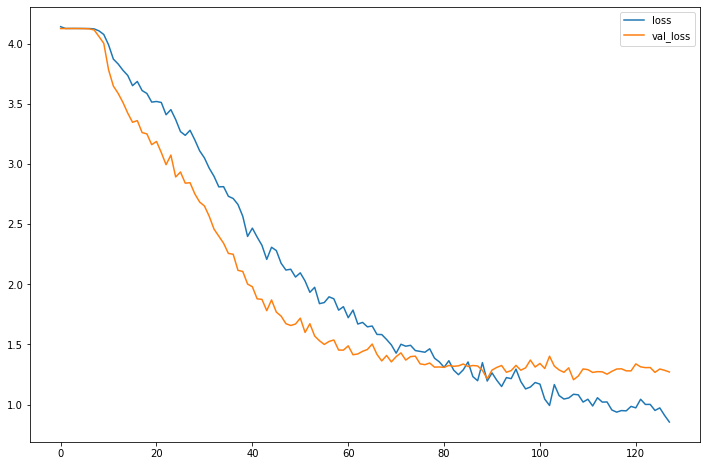

In [121]:
history = pd.DataFrame(model.history.history)
history[['loss','val_loss']].plot(figsize=(12, 8));

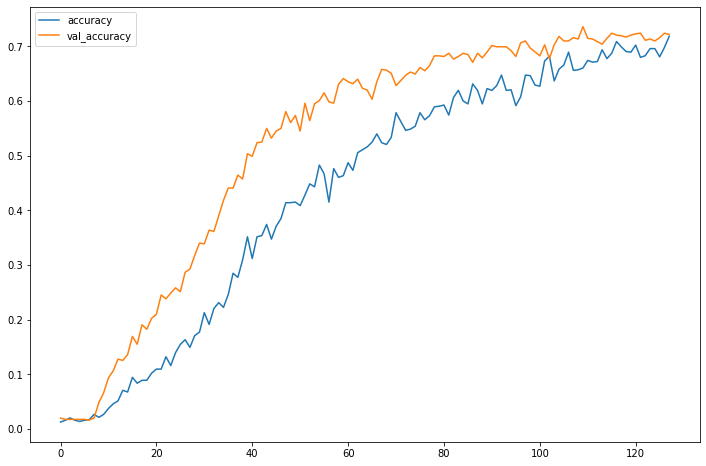

In [122]:
history[['accuracy', 'val_accuracy']].plot(figsize=(12, 8));

In [123]:
history.to_csv("history2.csv", index=False)

In [124]:
[val_loss, val_accuracy] = model.evaluate(validate_img_gen)
val_loss, val_accuracy

7/7 [==============================] - 2s 324ms/step - loss: 1.2713 - accuracy: 0.7216


(1.2712937593460083, 0.721563994884491)

In [125]:
[test_loss, test_accuracy] = model.evaluate(test_img_gen)
test_loss, test_accuracy

8/8 [==============================] - 3s 338ms/step - loss: 0.9297 - accuracy: 0.7387


(0.9297388195991516, 0.7387096881866455)

In [126]:
classes = list(test_img_gen.class_indices.keys())

In [127]:
pred_probabilities = model.predict(test_img_gen)

In [128]:
predictions = np.argmax(pred_probabilities, axis=1)

In [129]:
system = [ classes[p] for p in predictions ]

In [130]:
gold = [ classes[t] for t in test_img_gen.classes ]

In [131]:
print(classification_report(gold, system))

              precision    recall  f1-score   support

           0       0.39      0.73      0.51        15
           1       0.62      0.53      0.57        15
           2       0.94      1.00      0.97        15
           3       0.70      0.93      0.80        15
           4       0.94      1.00      0.97        15
           5       1.00      0.93      0.97        15
           6       0.82      0.93      0.87        15
           7       0.79      1.00      0.88        15
           8       0.94      1.00      0.97        15
           9       0.93      0.93      0.93        15
           A       0.94      1.00      0.97        15
           B       0.86      0.80      0.83        15
           C       0.60      0.40      0.48        15
           D       0.60      1.00      0.75        15
           E       1.00      0.87      0.93        15
           F       0.93      0.93      0.93        15
           G       0.80      0.80      0.80        15
           H       1.00    

In [132]:
print(confusion_matrix(gold, system))

[[11  0  0 ...  0  0  0]
 [ 0  8  0 ...  0  0  0]
 [ 0  0 15 ...  0  0  0]
 ...
 [ 0  0  0 ...  5  0  0]
 [ 0  0  0 ...  0 13  0]
 [ 0  0  0 ...  0  0  7]]


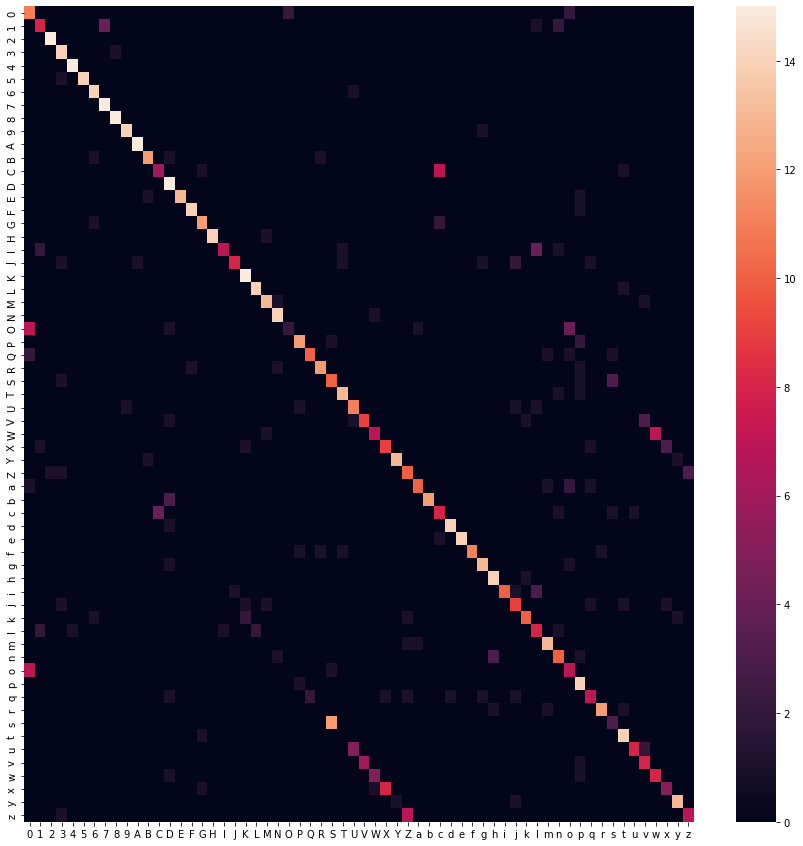

In [133]:
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(confusion_matrix(gold, system), xticklabels=classes, yticklabels=classes);

In [134]:
import os
import joblib
import json
import logging
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import load_model
from urllib.request import urlopen

In [135]:
# THIS WORKS, BUT SAVES THE FILE

#fname="file.png"
#if os.path.exists(fname):
#  os.remove(fname)
#pth_to_file = get_file(fname=fname, cache_dir=os.getcwd(), cache_subdir="", origin="https://raw.githubusercontent.com/KevinLeeCrosby/characters/main/GoodImg/Bmp/Sample001/img001-00004.png")
#img = load_img(pth_to_file, color_mode=color_mode, target_size=image_shape[:2])
#arr = img_to_array(img)
#arr = np.expand_dims(arr, axis=0)

#pred_probabilities = model.predict(arr)
#prediction = np.argmax(pred_probabilities, axis=1)
#system = [ classes[p] for p in prediction ] # singleton